In [12]:
import torch
from torch.autograd import Variable

import numpy as np
from __future__ import division
import time
from time import gmtime, strftime
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

import os
from os import listdir
from os.path import isfile, join

from utils import *
%matplotlib inline 

In [16]:
tensor = torch.FloatTensor([[1,2],[3,4]])
variable = Variable(tensor, requires_grad=True)
print tensor
print variable

t_out = torch.mean(tensor*tensor)
v_out = torch.mean(variable*variable)
print t_out
print v_out
v_out.backward()
print variable.grad


 1  2
 3  4
[torch.FloatTensor of size 2x2]

Variable containing:
 1  2
 3  4
[torch.FloatTensor of size 2x2]

7.5
Variable containing:
 7.5000
[torch.FloatTensor of size 1]

Variable containing:
 0.5000  1.0000
 1.5000  2.0000
[torch.FloatTensor of size 2x2]



In [3]:
#========================
# Environment Parameters
#======================== 
height = 10
width = 10

mazetype = 'none'
#obstacle density
obs_rho = 0

#place cells
place_cells = 700
#place cell full width half max (must be <1)
fwhm = 0.25

#make environment
maze = gridworld([height, width],rho=obs_rho,num_pc=place_cells, pc_fwhm=fwhm, maze_type=mazetype)

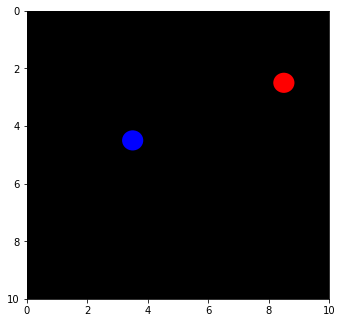

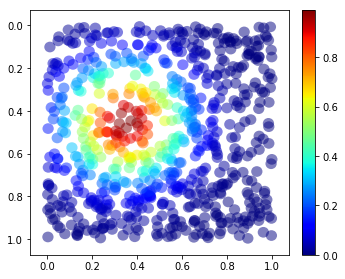

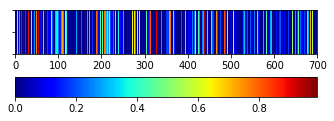

In [4]:
#========================
# Environment Plots
#======================== 

# plot maze -- agent (blue) and reward (red)
plt.figure()
fig = plt.figure()
axis  = fig.add_axes([0, 0, .7, 1]) # [left, bottom, width, height]

grid = maze.grid
useable_grid = maze.useable
rwd_loc = maze.rwd_loc
agent_loc = maze.cur_state


ax = fig.gca()
axis.pcolor(grid, cmap = 'bone', vmax =1, vmin = 0)

rwd_v, rwd_h = rwd_loc

agent_v, agent_h = agent_loc

ax.add_patch(plt.Circle((rwd_v+.5, rwd_h+.5), 0.35, fc='r'))
ax.add_patch(plt.Circle((agent_v+.5, agent_h+.5), 0.35, fc='b'))

ax.invert_yaxis()
#plt.colorbar()
plt.axis('tight')

#plot_grid(maze)


# plot place cells 
# circle radius given by fwhm of place cells (???)
fig = plt.figure()
ax  = fig.add_axes([0, 0.1, 0.6, 0.85]) # [left, bottom, width, height]
axc = fig.add_axes([0.63, 0.1, 0.03, 0.85])

cmap = plt.cm.jet
cNorm  = colors.Normalize(vmin=0, vmax=max(maze.pcs.activity(maze.cur_state)))
scalarMap = cmx.ScalarMappable(norm = cNorm, cmap=cmap)

for i in range(len(maze.pcs.x)):
    colorVal = scalarMap.to_rgba(maze.pcs.activity(maze.cur_state)[i])
    ax.add_patch(patches.Circle((maze.pcs.x[i], maze.pcs.y[i]), 0.025, fc=colorVal, ec='none', alpha=0.5))
    ax.set_ylim([1,0])
cb1 = mpl.colorbar.ColorbarBase(axc, cmap=cmap, norm=cNorm)
ax.axis('equal')
ax.axis('tight')

# plot input vector
fig = plt.figure()
ax  = fig.add_axes([0, 0.25, 0.7, 0.15]) # [left, bottom, width, height]
axc = fig.add_axes([0, 0.1, 0.7, 0.07])

ax.pcolor(maze.pcs.activity(maze.cur_state).reshape(1,maze.pcs.activity(maze.cur_state).shape[0]), vmin=0, vmax=1, cmap='jet')
ax.set_yticklabels([''])
cb2 = mpl.colorbar.ColorbarBase(axc, cmap = cmap, norm = cNorm, orientation='horizontal')

In [5]:
#=====================
# Training Parameters
#=====================
#trial parameters
NUM_TRIALS = 100000
NUM_EVENTS = 300
SAMPLE_TRIAL = NUM_TRIALS-1

discount_factor = 0.98
port_shift = 'none'


#gradient descent learning rate
eta = 1e-2

In [6]:
saveplots = False

if mazetype=='none':
    pathvar = './valplots/grid/{}/'.format(obs_rho)
    figpath = './figures/grid/{}/'.format(obs_rho)
else: 
    pathvar = './valplots/{}/'.format(mazetype)
    figpath = './figures/{}/'.format(mazetype)

if not os.path.exists(figpath):
    os.makedirs(figpath)
if saveplots:
    if not os.path.exists(pathvar):
        os.makedirs(pathvar)

In [ ]:
# Single run of NUM_TRIALS each with NUM_EVENTS
tf.reset_default_graph()

dims = [len(maze.net_state[0]),len(maze.actionlist)]

myAgent = agent(lr=eta, dims=dims)
#tf.summary.FileWriter('./outputs/maze3/', graph=tf.get_default_graph())

print_freq = 1./10
init = tf.global_variables_initializer()


with tf.Session() as sess:
    steps_rwd = []
    
    sess.run(init)
    
    pGrad_buf = sess.run(myAgent.policy_vars)
    vGrad_buf = sess.run(myAgent.value_vars)
    
    total_reward = []
    trialtime = []
    total_loss = [[],[]]

    blocktime = time.time()
    val_maps = []
    
    p_field = np.zeros((height, width), dtype=[('action_taken', 'i4'),('taken_prob', 'f4'), ('likely_action', 'i4'),('likely_prob', 'f4'), ('timestep', 'i4')])
    
    print strftime("%a, %d %b %Y %H:%M:%S +0000", time.localtime())
    for i in xrange(NUM_TRIALS):
        start_time = time.time()

        _ep_buffer = []
        reward_sum = 0

        # reset gradient buffers
        for ix,grad in enumerate(pGrad_buf):
            pGrad_buf[ix] = grad * 0
        for ix,grad in enumerate(vGrad_buf):
            vGrad_buf[ix] = grad * 0

        # reset the environment
        maze.start_trial()
        maze.value_map = maze.init_value_map
        
        state = maze.net_state
        
        for j in xrange(NUM_EVENTS): 
            # get policy and value estimate in order to select next action
            tfprob_, val_ = sess.run([myAgent.policy, myAgent.value], feed_dict={myAgent.input_layer:state})

            # process tensorflow lists to get right shape
            tfprob = tfprob_[0]
            val = val_[0][0]
            #print maze.cur_state, val, "###"
            maze.value_map[maze.cur_state[1]][maze.cur_state[0]] = val

            # select action
            choice = np.random.choice(np.arange(len(tfprob)), 1, p=tfprob)[0]
            action = maze.actionlist[choice]


            p_field[maze.cur_state[1]][maze.cur_state[0]] = (choice, list(tfprob)[choice], list(tfprob).index(max(list(tfprob))), max(list(tfprob)), i)
            
            # get new state of the environment and reward from action 
            if j < NUM_EVENTS:
                next_state = maze.move(action)

            rwd = maze.rwd

            # store buffer of agents experiences so that later we can calulate returns/etc. backwards through time
            _ep_buffer.append([state,choice,rwd,next_state, val])

            # update state
            state = next_state

            reward_sum += rwd
            
            #if maze.done == True: 
            #    trialtime.append(j)
            #    break
            #elif j == NUM_EVENTS-1:
            #    trialtime.append(NUM_EVENTS)
        # make data storage useable type 
        _ep_buffer = np.array(_ep_buffer)
        # compute returns
        _returns = discount_rwds(_ep_buffer[:,2], gamma=discount_factor)

        feed_dict = {myAgent.return_holder:_returns, myAgent.action_holder:_ep_buffer[:,1], myAgent.input_layer:np.vstack(_ep_buffer[:,0])}

        # calculate gradients using the information stored in the episode buffer
        # computed returns (backward through time)
        # which actions were taken gives which policy unit was responsible (so grads are computed properly)
        # pass states agent was in at each timestep through the network again to recompute the value and policy (for gradients computation in tf)
        a_loss, c_loss = sess.run([myAgent.actor_loss, myAgent.critic_loss], feed_dict=feed_dict)
        p_grads, v_grads = sess.run([myAgent.get_pol_grads, myAgent.get_val_grads], feed_dict=feed_dict)
        
        total_loss[0].append(a_loss)
        total_loss[1].append(c_loss)
        
        # store gradients in gradient buffers -- not necessary for the current formulation but will be more flexible for later
        # sorry for the additional complication 
        for idx, grad in enumerate(p_grads):
            pGrad_buf[idx] += grad

        for idx, grad in enumerate(v_grads):
            vGrad_buf[idx] += grad

        feed_dict = dict(zip(myAgent.p_gradient_holders, pGrad_buf)+zip(myAgent.v_gradient_holders, vGrad_buf))

        # run gradient update operations 
        _, __ = sess.run([myAgent.update_pol, myAgent.update_val], feed_dict = feed_dict)

        total_reward.append(reward_sum)
        val_maps.append(maze.value_map.copy())
        if saveplots:
            if (i%100 == 0):
                plt.clf()
                current_cmap = plt.cm.get_cmap()
                current_cmap.set_bad(color='white')
                plt.imshow(maze.value_map.copy(), vmin = 0, vmax=40, cmap = 'jet', interpolation='none')

                plt.annotate('*', np.add(maze.rwd_loc, (0, -0)), color='w')
                plt.title('{}'.format(i))
                #plt.gca().invert_yaxis()
                plt.colorbar()
                plt.savefig(pathvar+str(i),format='png')

        # print reward measure
        if i==1 or i%(print_freq*NUM_TRIALS)==0 or i == NUM_TRIALS-1: 
            print "Trial {0} finished in {1:.3f}. Total reward = {2} (Avg {3:.3f})".format(i, time.time()-start_time, reward_sum, float(reward_sum)/float(NUM_EVENTS)),
            print "Block took {0:.3f}".format(time.time()-blocktime)
            blocktime = time.time()


Mon, 27 Nov 2017 11:41:07 +0000
Trial 0 finished in 0.113. Total reward = 1 (Avg 0.003) Block took 0.113
Trial 1 finished in 0.113. Total reward = 0 (Avg 0.000) Block took 0.113


In [27]:
def make_gif(mypath, mazetype):
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    intfiles = [int(f) for f in onlyfiles]
    intfiles.sort()
    if mazetype =='none':
        gifname = './figures/gifs/grid{}.gif'.format(obs_rho)
    else: 
        gifname = './figures/gifs/{}.gif'.format(mazetype)
    

    with imageio.get_writer(gifname, mode='I', duration=0.5) as writer:
                for filename in intfiles:
                    image = imageio.imread(mypath+str(filename))
                    writer.append_data(image)
    print "Gif file saved at ", gifname

if saveplots:
    make_gif(pathvar, mazetype)

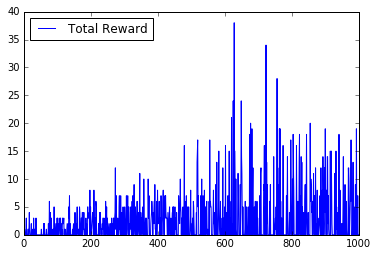

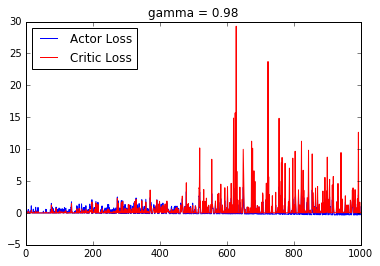

In [35]:
plt.clf()
plt.plot(total_reward, 'b-', label='Total Reward')
#plt.axhline(y=NUM_EVENTS*(0.983), color='r', linestyle='-', label='Minimum \nPefect Score')
plt.legend(loc=0)
plt.savefig(figpath+'{}_reward.svg'.format(mazetype), format = 'svg')
plt.show()

plt.clf()
plt.plot(total_loss[0], 'b', label = 'Actor Loss')
plt.title('gamma = {}'.format(discount_factor))
plt.plot(total_loss[1], 'r', label= 'Critic Loss')
plt.legend(loc=0)
plt.savefig(figpath+'{}_loss.svg'.format(mazetype), format = 'svg')
plt.show()

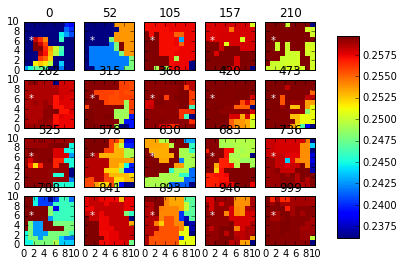

0.259705245495
1000


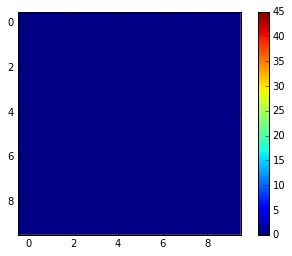

In [36]:
plotrows = 4
plotcols = 5
fig, axes = plt.subplots(nrows=plotrows, ncols=plotcols, sharex=True, sharey =True)
items = np.linspace(0, len(val_maps)-1, plotrows*plotcols)

for i, ax in enumerate(axes.flat):
    data = val_maps[int(items[i])]
    im = ax.pcolor(data, cmap= 'jet', vmin=np.nanmin(data), vmax=np.nanmax(data))
    im.cmap.set_under('white')
    ax.invert_yaxis()
    ax.annotate('*', np.add(maze.rwd_loc, (-0, .5)), color='w')
    ax.set_title('{}'.format(int(items[i])))


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
if mazetype == 'none':
    plt.savefig('./figures/grid_obs{}_valuemap.svg'.format(obs_rho), format='svg')
else: 
    plt.savefig('./figures/{}_valuemap.svg'.format(mazetype), format='svg')
plt.show()

print np.nanmax(val_maps)

data = val_maps[-1]
print len(val_maps)
plt.imshow(data, vmin=0, vmax=45, cmap='jet', interpolation='none')
plt.colorbar()
plt.show()

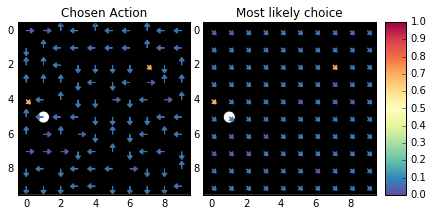

In [37]:
data = val_maps[-1].copy()
data[np.where(data>0)] = 0

## Plot actual choice
fig = plt.figure()

cmap = plt.cm.Spectral_r
cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm = cNorm, cmap=cmap)


ax1  = fig.add_axes([0.04, 0, 0.4, 0.85]) # [left, bottom, width, height]
ax2   = fig.add_axes([0.47, 0, 0.4, 0.85]) # [left, bottom, width, height]
axc = fig.add_axes([0.89, 0.125, 0.05, 0.6])

cb1 = mpl.colorbar.ColorbarBase(axc, cmap=cmap, norm=cNorm)

ax1.imshow(data, vmin=0, vmax=1, cmap='bone', interpolation='none')
ax1.add_patch(patches.Circle(maze.rwd_loc, 0.35, fc='w'))

ax2.imshow(data, vmin=0, vmax=1, cmap='bone', interpolation='none')
ax2.add_patch(patches.Circle(maze.rwd_loc, 0.35, fc='w'))


# p_field indicies
# 0 - choice, 
# 1 - list(tfprob)[choice], 
# 2 - list(tfprob).index(max(list(tfprob))), 
# 3 - max(list(tfprob)), 
# 4 - i)

for i in range(0, p_field.shape[0]):
    for j in range(0, p_field.shape[1]):
        dx1, dy1, head_w1, head_l1 = make_arrows(p_field[i][j][0], p_field[i][j][1]) 
        if (dx1, dy1) == (0,0):
            pass
        else:
            colorVal1 = scalarMap.to_rgba(p_field[i][j][1])
            ax1.arrow(j, i, dx1, dy1, head_width =0.3, head_length =0.2, color=colorVal1, alpha = 1 - ((len(val_maps)-p_field[i][j][4])/len(val_maps)))
            
        dx2, dy2, head_w2, head_l2 = make_arrows(p_field[i][j][2], p_field[i][j][3])
        if (dx2, dy2) == (0,0):
            pass
        else:
            colorVal2 = scalarMap.to_rgba(p_field[i][j][1])
            ax2.arrow(j, i, dx2, dy2, head_width =0.3, head_length =0.2, color=colorVal2, alpha = 1 - ((len(val_maps)-p_field[i][j][4])/len(val_maps)))
            
ax1.set_title("Chosen Action")
ax2.set_title("Most likely choice")
plt.savefig('./figures/{}choice_field.svg'.format(mazetype),format ='svg')
plt.show()